<h1 align="center">Titanic Dataset Analysis with Linear Models</h1>

<img src="https://img.20mn.fr/CErtKaVbRdGYu9BfHjihKA/640x410_leonardo-dicaprio-kate-winslet-titanic.jpg" width="1280" height="820" align="center"/> 
<h3 align="center">ANGELOT Quentin, LAMONTAGNE Simon, QUEYRICHON Samuel</h3>

# 0 / Imports
### 0.1 Bibliothèques


In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
import re
from warnings import simplefilter
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import RFECV


sns.set(color_codes=True)
%matplotlib inline
py.offline.init_notebook_mode(connected=True)
np.random.seed(64)
simplefilter(action='ignore', category=FutureWarning)

### 0.2 Datasets
Note : les datasets doivent être dans le même dossier que le notebook.

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
data = [train_df, test_df]

# 1 / Exploration du Dataset
## 1.1 Exploration préliminaire

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Le dataset d'entraînement a 891 lignes (valeurs) et 11 features, ainsi que la variable cible (Survived)**. 2 de ces features sont des floats, 5 sont des ints, et 5 sont des objets. Voici le détail du sens profane de ces features :

**PassengerId** : ID unique du passager<br>
**Survived** : État de vie du passager<br>
**Pclass** : Classe du ticket<br>
> *1 = 1ère classe / 2 = 2ème classe / 3 = 3ème classe*<br>

**Name** : Nom du passager<br>
> *à noter que le nom du passager varie en fonction de son sexe*<br>

**Sex** : Genre du passager<br>
**Age** : Age du passager<br>
**SibSp** : Nombre de frères/soeurs/conjoints à bord du Titanic<br>
**Parch** : Nombre de parents/enfants à bord<br>
**Ticket** : Numero de ticket du passager<br>
**Fare** : Tarif par passager<br>
**Cabin** : Numero de cabine des passagers<br>
**Embarked** : Port d'embarquement<br>  
> *C = Chebourg / Q = Queenstown / S = Southampton*


## 1.2 Exploration des types et des valeurs manquantes

In [4]:
print('Colonne - Type - Nombre de valeurs uniques - %age de valeurs présentes')
print('----------------------------------------------------------------------')
for col in train_df.columns:
    print('%s - %s - %s - %s'%(col,
                               train_df[col].dtypes,
                               len(train_df[col].unique()),
                               int(len(train_df[train_df[col].isnull() == False]) / len(train_df) * 100)))

Colonne - Type - Nombre de valeurs uniques - %age de valeurs présentes
----------------------------------------------------------------------
PassengerId - int64 - 891 - 100
Survived - int64 - 2 - 100
Pclass - int64 - 3 - 100
Name - object - 891 - 100
Sex - object - 2 - 100
Age - float64 - 89 - 80
SibSp - int64 - 7 - 100
Parch - int64 - 7 - 100
Ticket - object - 681 - 100
Fare - float64 - 248 - 100
Cabin - object - 148 - 22
Embarked - object - 4 - 99


On constate que la colonne **Cabin** a un grand nombre de valeurs nulles.
Que la colonne **Embarked** a quelques valeurs nulles (4 exactement)
Que la colonne **Age** a environ 20% de valeurs nulles.

## 1.3 Exploration des données statistiques globales

Commençons par afficher la dataframe et sa méthode describe()

In [5]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


En observant la dataframe, on peut déjà voir qu'on va devoir convertir plusieurs features pour les rendre **numériques**, afin que les algorithmes puissent les traiter. On remarque aussi que les échelles de valeurs sont extremement variés, et qu'on va devoir arranger ça pour qu'elles soient toutes à peu près dans les mêmes échelles.


On peut constater que **38%** des passagers présents dans le dataset ont survécu au naufrage du Titanic. 
Également, leurs âge sont très variés, allant de **5 mois à 80 ans**.


# 2 / Visualisation Exploratoire
On fait des visualisations de données simples sur le dataset brut, afin de se donner une idée des résultats qu'on attends.

#### 2.1 Repartition des Survivants/Morts

On vérifie qu'effectivement, 38% du dataset a survécu au naufrage.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f32e02cc990>],
      dtype=object)

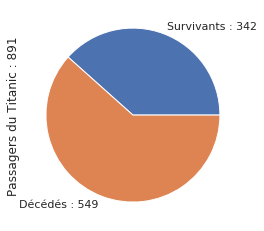

In [7]:
# Survived
a = train_df['Survived'].value_counts()
b = pd.Series({'Survivants : %s'%a[1] : a[1], 'Décédés : %s'%a[0] : a[0]})
b.plot(kind='pie', label='Passagers du Titanic : %s'%(a[0] + a[1]), subplots=True)

#### 2.2 Repartition des classes

On observe qu'une majorité des passagers étaient en 3ème classe.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f32dfa49350>],
      dtype=object)

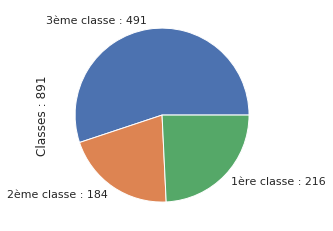

In [8]:
a = train_df['Pclass'].value_counts()
b = pd.Series({'3ème classe : %s'%a[3] : a[3], '2ème classe : %s'%a[2] : a[2], '1ère classe : %s'%a[1] : a[1]})
b.plot(kind='pie', label='Classes : %s'%(a[3] + a[1] + a[2]), subplots=True)

#### 2.3 Tranches d'âge

On observe que la repartition des âges des passagers s'approche d'une loi normale, et que la majorité des passagers avaient entre 10 et 40 ans.

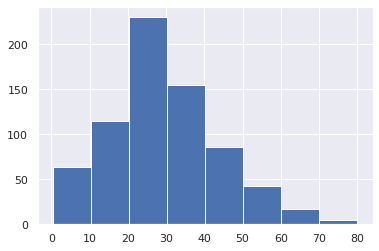

In [9]:
train_df['Age'].hist(bins=8)

# 3 / Preprocessing

## 3.1 Nettoyage et Numerisation des données

#### 3.1.1 Suppression des colonnes inutiles

**PassengerId** n'est pas une variable au sens statistique, on la supprime.<br>
**Ticket** est trop vague pour être intéressante et n'est pas transformable, pareil.

In [10]:
# dropping PassengerId from the train set
train_df = train_df.drop(['PassengerId'], axis=1)
# dropping Ticket from both sets
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

#### 3.1.2 Conversion et suppression de Cabin

**Cabin** se présente sous un format Pont-Numero de Chambre (ex : C128). En l'état, ça représente trop de valeurs différentes. Pour régler ce problème, on va ignorer le numero de chambre et se contenter d'obtenir le pont. Dans le même temps, on traite les données manquantes de cette colonne en attribuant les NaN à un pont fictif qu'on appellera U. On peut faire ça parce que le dataset comprends les numeros de chambre des passagers de 1ère classe uniquement, et donc que tout les passagers ayant une cabine sur le pont U sont dans une classe similaire.

In [11]:
# converting Cabin to Deck then dropping it
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype('int64')
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

#### 3.1.3 Extrapolation des données d'Âge manquantes

La colonne **Age** a 20% de valeurs manquantes, on va donc créer ces données en se basant sur la moyenne et l'écart-type des données qu'on a. Pour chaque valeur manquante, on crée une valeur aléatoire à partir de ces données statistiques.

In [12]:
# filling Age missing values with random values computed from the mean and std
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute as much random numbers between the mean and std as there are null values in the set
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype('int64')
train_df["Age"].isnull().sum()

0

#### 3.1.4 Remplacement des deux valeurs manquantes de la colonne Embarked

Ici, vu qu'on a une quantité de valeurs manquantes marginales, on fait une approximation et on admets que les deux passagers clandestins ont embarqué à Southampton.

In [13]:
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

#### 3.1.5 Traitement des valeurs manquantes et numerisation de la colonne Fare

In [14]:
#Fare
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype('int64')

#### 3.1.6 Creation de la colonne Titre

On utilise une expression régulière pour récupérer le titre de chaque passager dans la colonne Nom, on retire les valeurs manquantes, puis on créer une colonne "Titre" numerisée et on supprime la colonne "Name"

In [15]:
#Name
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extracting titles, regexes are trendy
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or put it in the new category 'Rare'
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # numerize titles
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

#### 3.1.7 Numerisation des colonnes Sex et Embarked

In [16]:
genders = {"male": 0, "female": 1}
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)
    
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

#### 3.1.8 Vérification

Par précaution, on affiche la dataframe et sa méthode info(). Normalement, toutes nos colonnes sont des int64.

In [17]:
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title
0,0,3,0,22,1,0,7,0,8,1
1,1,1,1,38,1,0,71,1,3,3
2,1,3,1,26,0,0,7,0,8,2
3,1,1,1,35,1,0,53,0,3,3
4,0,3,0,35,0,0,8,0,8,1
5,0,3,0,19,0,0,8,2,8,1
6,0,1,0,54,0,0,51,0,5,1
7,0,3,0,2,3,1,21,0,8,4
8,1,3,1,27,0,2,11,0,8,3
9,1,2,1,14,1,0,30,1,8,3


In [18]:
train_df.info()
traind_df2 = train_df.copy()
# df non normalisé pour les tests statistiques

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int64
Age         891 non-null int64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null int64
Embarked    891 non-null int64
Deck        891 non-null int64
Title       891 non-null int64
dtypes: int64(10)
memory usage: 69.7 KB


## 3.2 Catégorisation des données

#### 3.2.1 Categorisation des tranches d'ages

On catégorise les âges en 8 tranches, de façon à avoir un nombre de passagers à peu près équivalent dans chaque tranche, et on les numérise.

In [19]:
# Age into 8 groups, bruteforce method
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype('int64')
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 7

#### 3.2.2 Categorisation des tarifs

On catégorise (qcut <3) les tarifs en 6 groupes, et on les numérise.

In [20]:
# fares into 8 groups, qcut method
train_df['Fare'] = pd.qcut(train_df['Fare'], 6, labels=[0,1,2,3,4,5])
train_df['Fare'] = train_df['Fare'].astype('int64')

#### 3.2.3 Vérification

On utilise des value_counts() pour s'assurer qu'on a bel et bien des catégories à peu près égales.

In [21]:
train_df['Age'].value_counts()

4    155
6    153
3    144
5    143
2    123
1     98
0     68
7      7
Name: Age, dtype: int64

In [22]:
train_df['Fare'].value_counts()

0    241
3    165
5    146
2    146
4    123
1     70
Name: Fare, dtype: int64

## 3.3 Creation de nouvelles catégories

#### 3.3.1 Age selon la classe

In [23]:
# Age times class
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

#### 3.3.2 Familles 

On fusionne SibSp et Parch pour obtenir la taille de la famille de chaque passager et on numérise.

In [24]:
# Relatives
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype('int64')

#### 3.3.3 Prix par personne au sein d'une famille

On calcule le prix par personne que chaque famille à payé, et on numérise encore une fois.

In [25]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype('int64')

#### 3.3.4 Vérification

In [26]:
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,Age_Class,relatives,not_alone,Fare_Per_Person
0,0,3,0,2,1,0,0,0,8,1,6,1,0,0
1,1,1,1,5,1,0,5,1,3,3,5,1,0,2
2,1,3,1,3,0,0,0,0,8,2,9,0,1,0
3,1,1,1,5,1,0,5,0,3,3,5,1,0,2
4,0,3,0,5,0,0,1,0,8,1,15,0,1,1
5,0,3,0,2,0,0,1,2,8,1,6,0,1,1
6,0,1,0,6,0,0,4,0,5,1,6,0,1,4
7,0,3,0,0,3,1,3,0,8,4,0,4,0,0
8,1,3,1,3,0,2,2,0,8,3,9,2,0,0
9,1,2,1,1,1,0,4,1,8,3,2,1,0,2


In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived           891 non-null int64
Pclass             891 non-null int64
Sex                891 non-null int64
Age                891 non-null int64
SibSp              891 non-null int64
Parch              891 non-null int64
Fare               891 non-null int64
Embarked           891 non-null int64
Deck               891 non-null int64
Title              891 non-null int64
Age_Class          891 non-null int64
relatives          891 non-null int64
not_alone          891 non-null int64
Fare_Per_Person    891 non-null int64
dtypes: int64(14)
memory usage: 97.6 KB


On a désormais 14 colonnes, toutes sont des int64, et leurs valeurs sont normalisées. Notre algorithme va pouvoir travailler dessus.

# 4 / Analyse des données

Maintenant que les données sont nettoyées, on va pouvoir explorer notre dataset un peu plus en profondeur et faire des hypothèses dessus, qu'on va vérifier à l'aide de tests statistiques.

## 4.1 Visualisation analytique

On fait quelques visualisations pour se donner des pistes de reflexion sur les hypothèses qu'on va faire

#### 4.1.1 Taille des familles selon la classe

On trace des boites à moustache, qui nous permettent de constater que les familles sont significativement plus grandes dans la 3ème classe.

In [28]:
first = train_df['relatives'].where(train_df["Pclass"] == 1 )
second = train_df['relatives'].where(train_df["Pclass"] == 2 )
third = train_df['relatives'].where(train_df["Pclass"] == 3 )

df = pd.DataFrame({'1': first,
                   '2': second,
                   '3': third})

fig = df.iplot(asFigure=True, title='Family size by classes', kind="box")
fig.show()

#### 4.1.2 Survie selon la classe, l'âge, le prix du billet et la taille de la famille

**Légende** : <br>
> Losange = Survivant<br>
Rond = Décédé<br>

> Jaune = 3ème classe<br>
Rouge = 2ème classe<br>
Bleu = 1ère classe<br>

Ce plot est chargé d'infos, et nous permet de tirer plusieurs hypothèses :<br>

- *Avoir payé son ticket plus cher augmente les chances de survie*
- *Avoir une grande famille diminue les chances de survie*
- *Être en 3ème classe diminue grandement les chances de survie*
- *L'âge n'influe que peu sur les chances de survie*

In [29]:
df = train_df[['Survived', 'Pclass', 'Age', 'relatives', 'Fare_Per_Person']]
fig = px.scatter_3d(df, x='Age', y='relatives', z='Fare_Per_Person',
              symbol ='Survived', color='Pclass', opacity=0.7)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

#### 4.1.3 Matrice de Corrélation

On observe plusieurs corrélations intéressantes :

- *Survived avec Sex, Fare, Title, et Fare_Per_Person*
- *Pclass avec Fare et Fare_Per_Person*
- *Sex avec Title*
- *SibSp, Parch, relatives et not_alone tous ensembles, ce qui est logique considérant qu'ils sont tous basés sur les mêmes données*
- *Deck avec Fare_Per_Person, Fare, et not_alone*

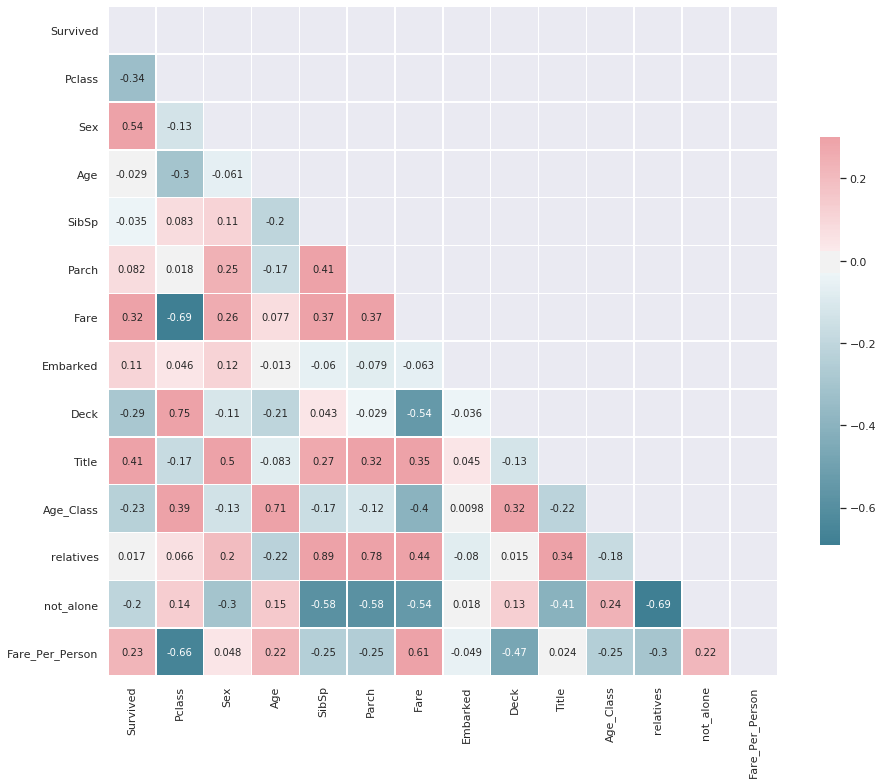

In [30]:
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(15, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

## 4.2 Hypothèses et Tests statistiques

#### 4.2.1 Hypothèse : L'age influe sur les chances de survie

In [31]:
from scipy.stats import probplot, ttest_ind, chi2_contingency

traind_df2['binarize_age'] = pd.cut(traind_df2['Age'], bins=[0,18,100])
age = traind_df2['binarize_age'].cat.codes

ttest_ind(age,traind_df2.Survived)

Ttest_indResult(statistic=19.692988900915648, pvalue=2.9073524013520553e-78)

#### 4.2.2 Hypothèse : Le sexe influe sur les chances de survie

In [41]:
sex = traind_df2['Sex'].astype('category').cat.codes

cross_ = pd.crosstab(sex,traind_df2['Survived'])
chi2, p, dof, ex = chi2_contingency(cross_)
chi2, p

(260.71702016732104, 1.1973570627755645e-58)

#### 4.2.3 Hypothèse : Le prix du billet influe sur les chances de survie

In [37]:
traind_df2['binarize_fare'] = pd.cut(traind_df2['Fare'], bins=[0,60,515])
bin_fare = traind_df2['binarize_fare'].cat.codes 

cross = pd.crosstab(index=bin_fare,
            columns=traind_df2['Survived'])
cross.drop(-1, axis=0)

Survived,0,1
row_0,,
0,495,259
1,40,82


In [38]:
g, p, dof, expctd = chi2_contingency(cross)
g, p

(54.440525485130046, 1.5079609490025033e-12)

# 5 / Machine Learning

## 5.1 Regression Linéaire